In [2]:
# POde pular essa etapa se os pacotes já estão instalados
!pip install numpy
!pip install scikit-learn
!pip install scikit-image
!pip install librosa
!pip install tqdm
!pip install matplotlib
!pip install tensorflow

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)
^C
ERROR: Operation cancelled by user
  Using cached scikit_image-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metad

In [9]:
#ref: https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import librosa
import librosa.display
import pywt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation, TimeDistributed

#to play audio
import IPython.display as ipd

# Nesse caso você precisa ter no seu diretório uma pasta com o mesmo nome da variável base_dir
base_dir = "audioset"
# E dentro da pasta audioset, você precisa de 3 pastas: carros, motocicletas e motosserras contendo os áudios
audio_carro_path = base_dir + "/carros/"
audio_moto_path = base_dir + "/motocicletas/"  # caminho onde estão os arquivos de audio
audio_serra_path = base_dir + "/motosserras/"

# Caminho onde vão ficar os espectrogramas
spec_base_path = "./audioset/MFCC"
spec_carro_path = os.path.join(spec_base_path, "carros")
spec_moto_path = os.path.join(spec_base_path, "motocicletas")
spec_serra_path = os.path.join(spec_base_path, "motosserras")
 
os.makedirs(spec_base_path, exist_ok=True)
os.makedirs(spec_carro_path, exist_ok=True)
os.makedirs(spec_moto_path, exist_ok=True)
os.makedirs(spec_serra_path, exist_ok=True)

In [2]:
audio_carro_clips = sorted(os.listdir(audio_carro_path))[:250]
print(f"Número de arquivos .wav na pasta {audio_carro_path}= ",len(audio_carro_clips))

audio_moto_clips = sorted(os.listdir(audio_moto_path))[:250]
print(f"Número de arquivos .wav na pasta {audio_moto_path}= ",len(audio_moto_clips))

audio_serra_clips = sorted(os.listdir(audio_serra_path))[:500]
print(f"Número de arquivos .wav na pasta {audio_serra_path}= ",len(audio_serra_clips))

Número de arquivos .wav na pasta audioset/carros/=  250
Número de arquivos .wav na pasta audioset/motocicletas/=  250
Número de arquivos .wav na pasta audioset/motosserras/=  500


# TESTE DWT

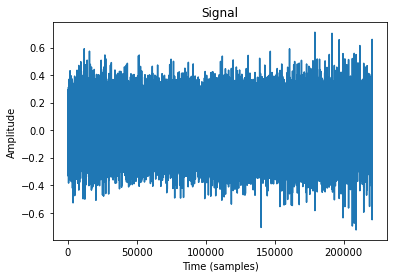

In [37]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
y, sr = librosa.load(audio_serra_path+audio_serra_clips[6])
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

In [38]:
sr

22050

In [39]:
# Definir tamanho do segmento e número de segmentos
segment_length = 512  # Tamanho de cada segmento
num_segments = 128  # Número total de segmentos para matriz 128 x 128

# Certificar-se de que o áudio é longo o suficiente
if len(y) < segment_length * num_segments:
    raise ValueError("O arquivo de áudio é muito curto para gerar uma matriz 128 x 128.")

# Definir parâmetros para a Wavelet Packet Transform usando "haar" no nível 7
wavelet_level = 7
n_packets = 2 ** wavelet_level  # 128 pacotes no nível 7

# Criar uma matriz para armazenar as características para cada segmento
features_wl = np.zeros((num_segments, n_packets))

# Processar cada segmento do áudio
for i in range(num_segments):
    start_idx = i * segment_length  # Índice de início do segmento
    end_idx = start_idx + segment_length  # Índice de fim do segmento
    segment = y[start_idx:end_idx]  # Extrair o segmento
    
    # Aplicar a Wavelet Packet Transform no nível 7
    wp = pywt.WaveletPacket(data=segment, wavelet="haar", maxlevel=wavelet_level)
    
    # Obter os nomes dos pacotes no nível desejado
    packet_names = [node.path for node in wp.get_level(wavelet_level, "natural")]
    
    # Calcular a energia para cada pacote no nível desejado
    for j in range(n_packets):
        packet = wp[packet_names[j]].data  # Obter os dados do pacote
        features_wl[i, j] = np.linalg.norm(packet) ** 2  # Calcular a energia (norma quadrada)
    
    # Normalizar pela energia total do segmento
    total_energy = np.sum(features_wl[i, :])
    features_wl[i, :] = features_wl[i, :] / total_energy  # Normalizar pela energia total

# Agora, temos um array de características com dimensões 128 x 128
print("Matriz de características (128 x 128):")
print(features_wl)

Matriz de características (128 x 128):
[[0.00070081 0.0019805  0.00219305 ... 0.00373578 0.00541938 0.00636108]
 [0.0003715  0.00108164 0.025655   ... 0.00352687 0.00752169 0.0043784 ]
 [0.00120504 0.0004641  0.01550889 ... 0.0064796  0.00731102 0.0011147 ]
 ...
 [0.00187512 0.00275595 0.00097239 ... 0.00549051 0.00193736 0.00259548]
 [0.00254249 0.00393276 0.00813238 ... 0.0027695  0.00192549 0.00429663]
 [0.00159768 0.00085804 0.01117599 ... 0.00312558 0.00453773 0.00498656]]


Array final com características normalizadas:
[[0.00070081 0.0019805  0.00219305 ... 0.00373578 0.00541938 0.00636108]
 [0.0003715  0.00108164 0.025655   ... 0.00352687 0.00752169 0.0043784 ]
 [0.00120504 0.0004641  0.01550889 ... 0.0064796  0.00731102 0.0011147 ]
 ...
 [0.00177503 0.01716737 0.08290559 ... 0.00246009 0.00733298 0.00212283]
 [0.0089186  0.01951063 0.06967004 ... 0.00364967 0.01297279 0.00520917]
 [0.00512061 0.0054315  0.03647479 ... 0.00462817 0.0019928  0.00742271]]


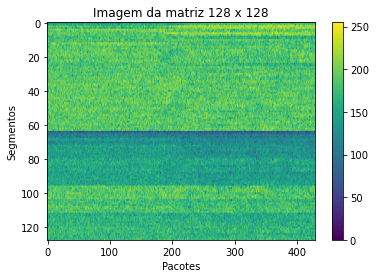

In [43]:
# Tamanho do segmento (512 pontos)
segment_length = 512
num_segments = len(y) // segment_length  # Calcular o número de segmentos

# Definir parâmetros para a Wavelet Packet Transform usando "haar"
wavelet_level = 7  # Nível desejado de decomposição
n_packets = 2 ** wavelet_level  # Número de pacotes para o nível 3

# Criar um array para armazenar características para cada segmento
# Dimensão desejada é 128 x 128
features_wl = np.zeros((num_segments, n_packets))

# Processar cada segmento do áudio
for i in range(num_segments):
    # Extrair o segmento de áudio
    start_idx = i * segment_length  # Início do segmento
    end_idx = start_idx + segment_length  # Fim do segmento
    segment = y[start_idx:end_idx]  # Extrair o segmento do áudio
    
    # Aplicar a Wavelet Packet Transform
    wp = pywt.WaveletPacket(data=segment, wavelet="haar", maxlevel=wavelet_level)
    
    # Obter os nomes dos pacotes no nível desejado
    packet_names = [node.path for node in wp.get_level(wavelet_level, "natural")]
    
    # Calcular a energia para cada pacote
    for j in range(n_packets):
        packet = wp[packet_names[j]].data
        features_wl[i, j] = np.linalg.norm(packet) ** 2
    
    # Normalizar a energia total do segmento
    total_energy = np.sum(features_wl[i, :])
    features_wl[i, :] = features_wl[i, :] / total_energy

# A saída é um array de dimensões 128 x 128
print("Array final com características normalizadas:")
print(features_wl)

# Gerar uma imagem a partir da matriz 128 x 128
features_wl = np.log(features_wl.T)
features_wl_novo= (features_wl-features_wl.min())/(features_wl.max()-features_wl.min())*255
plt.imshow(features_wl_novo, aspect='auto', cmap='viridis')  # Usar um mapa de cores
plt.colorbar()  # Adicionar uma barra de cores para escala
plt.title("Imagem da matriz 128 x 128")
plt.xlabel("Pacotes")
plt.ylabel("Segmentos")
plt.show()  # Mostrar a imagem

In [41]:
features_wl.shape

(430, 128)

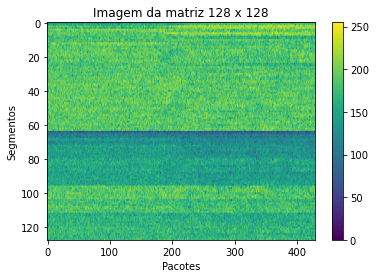

In [42]:
# Gerar uma imagem a partir da matriz 128 x 128
features_wl = np.log(features_wl.T)
features_wl_novo= (features_wl-features_wl.min())/(features_wl.max()-features_wl.min())*255
plt.imshow(features_wl_novo, aspect='auto', cmap='viridis')  # Usar um mapa de cores
plt.colorbar()  # Adicionar uma barra de cores para escala
plt.title("Imagem da matriz 128 x 128")
plt.xlabel("Pacotes")
plt.ylabel("Segmentos")
plt.show()  # Mostrar a imagem

fim dessa parte

In [3]:
#aqui está selecionando o primeiro arquivo da lista, pode ser feito um for para pegar todos de uma vez
#verificar esse sample rate
x_carro, sr_carro = librosa.load(audio_carro_path+audio_carro_clips[0]) 
x_moto, sr_moto = librosa.load(audio_moto_path+audio_moto_clips[4]) 
x_serra, sr_serra = librosa.load(audio_serra_path+audio_serra_clips[6]) 

print(type(x_carro), type(sr_carro))
print(x_carro.shape, sr_carro)

print(type(x_moto), type(sr_moto))
print(x_moto.shape, sr_moto)

print(type(x_serra), type(sr_serra))
print(x_serra.shape, sr_serra)

<class 'numpy.ndarray'> <class 'int'>
(220500,) 22050
<class 'numpy.ndarray'> <class 'int'>
(220500,) 22050
<class 'numpy.ndarray'> <class 'int'>
(220500,) 22050


In [4]:
#converter o audio para espectrograma:
# é nesse amplitude_to_dB que ele está convertendo para pressão sonora. Podemos explorar outras ponderações aqui. Se não tiver implementado, podemos implementar.
def salvar_espectrograma(y, sr, spec_path, log=False):

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096)
    mel_spect = librosa.power_to_db(spect, ref=np.max)

    plt.figure(figsize=(1, 1))

    if log:
        librosa.display.specshow(mel_spect, x_axis='time', y_axis='log', fmax=8000)
    else: librosa.display.specshow(mel_spect, x_axis='time', y_axis='mel', fmax=8000)
    plt.margins(0,0)
    
    plt.axis("off")
    plt.savefig(spec_path, dpi=300, bbox_inches = 'tight',
                pad_inches = 0, transparent=False, facecolor='white')
    plt.close()

    print(f"{spec_path} salvo com sucesso.")

# Salvar imagens de espectrograma
 - Pule esse passo se as imagens já estiverem na pasta

In [13]:
# Salvar espectrogramas de carros
for audio_name in audio_carro_clips:
    x_carro, sr_carro = librosa.load(audio_carro_path + audio_name) 
    audio_name = audio_name.replace(".mp3", ".png")
    spec_path = os.path.join(spec_carro_path, audio_name)
    try:
        salvar_espectrograma(x_carro, sr_carro, spec_path)
    except:
        print("Erro ao salvar arquivo %s" % spec_path)

# Salvar espectrogramas de motos
for audio_name in audio_moto_clips:
    x_moto, sr_moto = librosa.load(audio_moto_path + audio_name) 
    audio_name = audio_name.replace(".mp3", ".png")
    spec_path = os.path.join(spec_moto_path, audio_name)
    try:
        salvar_espectrograma(x_moto, sr_moto, spec_path)
    except:
        print("Erro ao salvar arquivo %s" % spec_path)

# Salvar espectrogramas de motosserras
for audio_name in audio_serra_clips:
    x_serra, sr_serra = librosa.load(audio_serra_path + audio_name) 
    audio_name = audio_name.replace(".mp3", ".png")
    spec_path = os.path.join(spec_serra_path, audio_name)
    try:
        salvar_espectrograma(x_serra, sr_serra, spec_path)
    except:
        print("Erro ao salvar arquivo %s" % spec_path)

./audioset/mel_espectrogramas_com_log_8000Hz/carros/#5) Project ForkenSwift electric car： shifting gears-Liqv3KgXThk.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/$150 car jump-1aCyNnYNWvA.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/'87 Honda Mugen Motul Civic Si Race Car at Costa Di Almafi GT4-28SbkfcA6kE.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/'０７ STREET CAR SHOW  ＃６ 大黒２--NBRp5qsrYQ.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/(16) Car Cam： 2 mobile speed cameras, speed racer & scenic esplanade route-2JAjo7yVCgs.png salvo com sucesso.
Erro ao salvar arquivo ./audioset/mel_espectrogramas_com_log_8000Hz/carros/(HD) - Forza 4 - Top Gear - Car Test - 1967 Chevrolet Corvette Stingray 427--v2FkuCVLjo.png
./audioset/mel_espectrogramas_com_log_8000Hz/carros/(HD) - Forza 4 - Top Gear - Car Test - 1980 Lotus Esprit Turbo-1Z3ciuA3Y3o.png salvo com sucesso.
./audioset/mel_

/tmp/ipykernel_62255/1657064409.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1, 1))


./audioset/mel_espectrogramas_com_log_8000Hz/carros/12th Annual Popular Hot Rodding Championships- Funny Car-11cctCD0ATQ.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/1300 Saloon Stock Car - Lochgelly (World)-5CjYO0nqgW8.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/150 Race Car Hits Cameraman-1P6NL71uTiY.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/154 kp⧸h RC car crash into woods-18C6WBVH9zg.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/15ο ΡΑΛΛΥ ΚΟΡΙΝΘΟΥ 2011 HYUNDAI ACCENT A6 ΓΙΩΤΗΣ - ΒΟΤΣΗΣ IN CAR-3DVoDho5RKY.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/1600 rally car 2--qffkib86ZE.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/1600 rally car action-0MryoXgDsQo.png salvo com sucesso.
./audioset/mel_espectrogramas_com_log_8000Hz/carros/16th STREET CAR NATIONALS SUZUKA　②-2IgRckLK_wk.png salvo com sucesso.
./aud

# Treinamento e teste de rede neural

In [6]:
# Carregar espectrogramas com uma CNN e classificar entre "motosserras e não motosserras"

espectrogramas_carro = sorted(os.listdir(spec_carro_path))
espectrogramas_moto = sorted(os.listdir(spec_moto_path))
espectrogramas_serra = sorted(os.listdir(spec_serra_path))

lista_imagens = []
labels = []


def adicionar_rotulos_imagens(espectrogramas, espectro_path, label):
    for spec in espectrogramas:
        image_path = os.path.join(espectro_path, spec)     
        img = io.imread(image_path)
        lista_imagens.append(img[:, :, :-1])
        # 0 corresponde aos carros e motos
        labels.append(label)

adicionar_rotulos_imagens(espectrogramas_carro, spec_carro_path, 0)
adicionar_rotulos_imagens(espectrogramas_moto, spec_moto_path, 0)
adicionar_rotulos_imagens(espectrogramas_serra, spec_serra_path, 1)


X_train, X_test, y_train, y_test = train_test_split(
    np.array(lista_imagens), np.array(labels), test_size=0.2, random_state=100
)


(792, 226, 232, 3)


In [7]:

print(X_train.shape)

(792, 226, 232, 3)


In [12]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics='accuracy')
model.fit(X_train, y_train, batch_size=32 , epochs=15)

y_pred = model.predict(X_test)[:, 0]
y_pred = np.round(y_pred)
acc = len(np.where(y_pred == y_test)[0]) / len(y_test)
print("Acurácia:", acc)

Epoch 1/15
25/25 [==============================] - 41s 2s/step - loss: 15.5470 - accuracy: 0.5202
Epoch 2/15
25/25 [==============================] - 39s 2s/step - loss: 0.6922 - accuracy: 0.5997
Epoch 3/15
25/25 [==============================] - 38s 2s/step - loss: 1.4618 - accuracy: 0.5581
Epoch 4/15
25/25 [==============================] - 39s 2s/step - loss: 0.8158 - accuracy: 0.5934
Epoch 5/15
25/25 [==============================] - 39s 2s/step - loss: 0.7896 - accuracy: 0.6023
Epoch 6/15
25/25 [==============================] - 38s 2s/step - loss: 0.7279 - accuracy: 0.6023
Epoch 7/15
25/25 [==============================] - 39s 2s/step - loss: 0.7356 - accuracy: 0.6414
Epoch 8/15
25/25 [==============================] - 38s 2s/step - loss: 0.7656 - accuracy: 0.6578
Epoch 9/15
25/25 [==============================] - 40s 2s/step - loss: 0.5778 - accuracy: 0.7083
Epoch 10/15
25/25 [==============================] - 39s 2s/step - loss: 0.7047 - accuracy: 0.7109
Epoch 11/15
25/25 